In [1]:
# Remove warnings for anonymization of the paper
import warnings
warnings.warn = lambda *args, **kwargs: None
# ------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def sample_cat(p, soft=False, levels=False, rs=None, dtype=bool):
    flatten = len(p.shape) == 1
    if flatten:
        p = np.expand_dims(p, 1)
    if p.shape[1] == 1:
        p = np.concatenate([1 - p, p], 1)
    
    if rs is None:
        rs = np.random
        
    u = rs.uniform(size=p.shape)
    gumbel = -np.log(-np.log(u))
    
    score = np.log(p) + gumbel
    if soft:
        # Note that if soft, we can't return levels
        M = score.max(1, keepdim=True)
        log_x = score - (np.log(np.exp(score - M).sum(1)) + M)
        
        x = np.exp(log_x)
    else:
        argmax = np.argmax(score, 1)
        
        if levels:
            x = np.array(levels)[argmax]
        else:
            argmax = np.expand_dims(argmax, 1)
            x = np.expand_dims(np.arange(p.shape[1]), 0).repeat(len(p), 0) == argmax
        
    if levels and not soft:
        return x # already with the right shape
    else:
        x = x.astype(dtype)
        
        if flatten:
            x = x[:, 1]
        
        return x

In [3]:
N = 10000
rs = np.random.RandomState(seed=123)

experience = rs.exponential(size=N)
interests = rs.normal(size=N)

gender = rs.choice(range(2), replace=True, size=N, p=[.7, .3]).astype(bool)
age = rs.chisquare(10, size=N) * 2 + 16
_age_cdf = (np.expand_dims(age, 1) >= np.expand_dims(age, 0)).mean(1)

education = (np.sqrt(_age_cdf) * 2 - 1) + (-1 + .75 * rs.normal(size=N))
education = sigmoid(education)

_field_p = sigmoid(interests + (gender * 2 - 1) * 1.75)
field = sample_cat(_field_p, rs=rs, dtype=bool)

seniority = np.log(1 + 
    (1 + experience) * 
    (1 + education) * 
    (1 + gender * .25) ** 2 * 
    (1 - (1 - field) * .25) *
    (1 + _age_cdf ** 2)
)

#
salary = np.sqrt(education) * \
    np.sqrt(seniority) * (.75 * field + .5 * (1 - field))
salary = salary / salary.mean() * 10000 + 20000

# This will be used to filter out some individuals. 
# This generates a latent confounder via selection bias.
stay_at_home = (sample_cat(_age_cdf * .95 + .025, rs=rs) * (1 - gender)).astype(bool)

In [4]:
df = pd.DataFrame({
    'gender': gender,
    'field': field,
    'age': age,
    'education': education,
    'seniority': seniority,
    'salary': salary,
    
    'experience': experience,
    'interests': interests,
})

df = df[~stay_at_home].copy()

In [5]:
ax = df[df.gender].plot.scatter('education', 'salary', alpha=.1, color='C0')
df[~df.gender].plot.scatter('education', 'salary', alpha=.1, color='C1', ax=ax)

<AxesSubplot:xlabel='education', ylabel='salary'>

In [6]:
df.corr()

gender     field       age  education  seniority    salary  \
gender      1.000000  0.621088  0.291799   0.120555   0.591258  0.534246   
field       0.621088  1.000000  0.190483   0.083262   0.509520  0.638502   
age         0.291799  0.190483  1.000000   0.480074   0.532470  0.550459   
education   0.120555  0.083262  0.480074   1.000000   0.405223  0.743098   
seniority   0.591258  0.509520  0.532470   0.405223   1.000000  0.793049   
salary      0.534246  0.638502  0.550459   0.743098   0.793049  1.000000   
experience -0.012224 -0.004564 -0.014513  -0.004068   0.631226  0.200946   
interests   0.004717  0.272566  0.015758  -0.001605   0.065537  0.134474   

            experience  interests  
gender       -0.012224   0.004717  
field        -0.004564   0.272566  
age          -0.014513   0.015758  
education    -0.004068  -0.001605  
seniority     0.631226   0.065537  
salary        0.200946   0.134474  
experience    1.000000  -0.003309  
interests    -0.003309   1.000000

In [7]:
df[df.gender].age.plot.kde()
df[~df.gender].age.plot.kde()

<AxesSubplot:ylabel='Density'>

In [8]:
ax = pd.plotting.scatter_matrix(df.iloc[:, 2:], alpha=.05, figsize=(12, 8), c=np.array(['C0', 'C1'])[1 - df.gender]);

In [9]:
df.groupby('gender').salary.mean()

gender
False    27788.635904
True     33004.209440
Name: salary, dtype: float64

In [10]:
df.groupby('gender').field.mean()

gender
False    0.193787
True     0.816498
Name: field, dtype: float64

In [11]:
df.groupby('gender').age.mean()

gender
False    31.199046
True     35.922745
Name: age, dtype: float64

In [12]:
df.gender.mean()

0.45840407470288624

<AxesSubplot:>

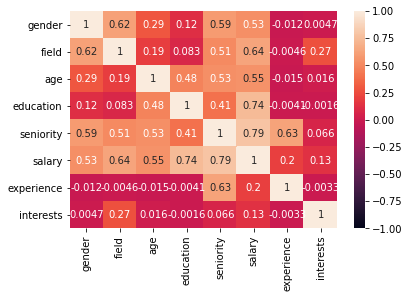

In [13]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

In [14]:
# Drop both latents now: experience and interests
df = df.drop(['experience', 'interests'], 1)

In [15]:
definition = \
'''stay_at_home lat 1
gender bern 1 stay_at_home
field bern 1 gender
age cont 1 stay_at_home
education cont 1 age
seniority cont 1 age education gender field
salary cont 1 education seniority field
'''

In [16]:
split = .8

n = int(len(df) * split)
train, test = df.iloc[:n], df.iloc[n:]

In [17]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

with open('definition.json', 'w') as f:
    f.write(definition)